In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
import random
import os
import shutil


In [ ]:
#veri setini alma
!git clone https://github.com/BIDS/BSDS500.git

Cloning into 'BSDS500'...
remote: Enumerating objects: 2380, done.
remote: Total 2380 (delta 0), reused 0 (delta 0), pack-reused 2380 (from 1)
Receiving objects: 100% (2380/2380), 155.21 MiB | 32.67 MiB/s, done.
Resolving deltas: 100% (139/139), done.
Updating files: 100% (2268/2268), done.


In [ ]:
#1) görsel seçimi
os.makedirs("images", exist_ok=True)

all_images = glob.glob("BSDS500/**/*.jpg", recursive=True)
random.seed(42)
selected_images = random.sample(all_images, 5)

for img in selected_images:
    shutil.copy(img, "images")

selected_images


['BSDS500/BSDS500/data/images/test/179084.jpg',
 'BSDS500/BSDS500/data/images/train/65019.jpg',
 'BSDS500/BSDS500/data/images/train/268002.jpg',
 'BSDS500/BSDS500/data/images/test/226043.jpg',
 'BSDS500/BSDS500/data/images/train/112082.jpg']

In [ ]:
#2) rgb - hsı dönüşümü
def rgb_to_hsi(img):
    img = img.astype(np.float32) / 255.0 #normalization
    B, G, R = cv2.split(img)

    # Intensity
    I = (R + G + B) / 3.0

    # Saturation
    min_rgb = np.minimum(np.minimum(R, G), B)
    S = 1 - (3 * min_rgb / (R + G + B + 1e-6))
    S = np.clip(S, 0, 1)

    # Hue-renk tonu
    num = 0.5 * ((R - G) + (R - B))
    den = np.sqrt((R - G)**2 + (R - B)*(G - B)) + 1e-6
    H = np.arccos(np.clip(num / den, -1, 1))
    H[B > G] = 2*np.pi - H[B > G]
    H = H / (2*np.pi)

    return H, S, I


In [ ]:
#3- mean shift tabanlı region-based segmentasyon
def mean_shift_segmentation(img_bgr):
    return cv2.pyrMeanShiftFiltering(
        img_bgr,
        sp=25,   # spatial radius
        sr=40    # color radius
    )


In [ ]:
#4- region labeling
def label_regions_from_meanshift(ms_img):
    gray = cv2.cvtColor(ms_img, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (5, 5), 0)

    _, binary = cv2.threshold(
        blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU
    )

    num_labels, labels = cv2.connectedComponents(binary)
    return labels, num_labels


In [ ]:
#5- Region Görselleştirme
def visualize_regions(labels):
    h, w = labels.shape
    output = np.zeros((h, w, 3), dtype=np.uint8)

    rng = np.random.default_rng(42)
    for label in np.unique(labels):
        if label == 0:
            continue
        color = rng.integers(0, 255, size=3) #rastgele renk atama
        output[labels == label] = color #etiketlere göre boyama

    return output


In [ ]:
#İYİLEŞTİRME 1: Küçük Region Birleştirme
def remove_small_regions(labels, min_area=400):
    cleaned = labels.copy()
    unique, counts = np.unique(labels, return_counts=True)
    area_map = dict(zip(unique, counts))

    for label, area in area_map.items():
        if label == 0:
            continue
        if area < min_area:
            cleaned[labels == label] = 0

    return cleaned


In [ ]:
#İYİLEŞTİRME 2: Mean Shift Parametre Denemesi
def mean_shift_custom(img, sp, sr):
    return cv2.pyrMeanShiftFiltering(img, sp=sp, sr=sr)


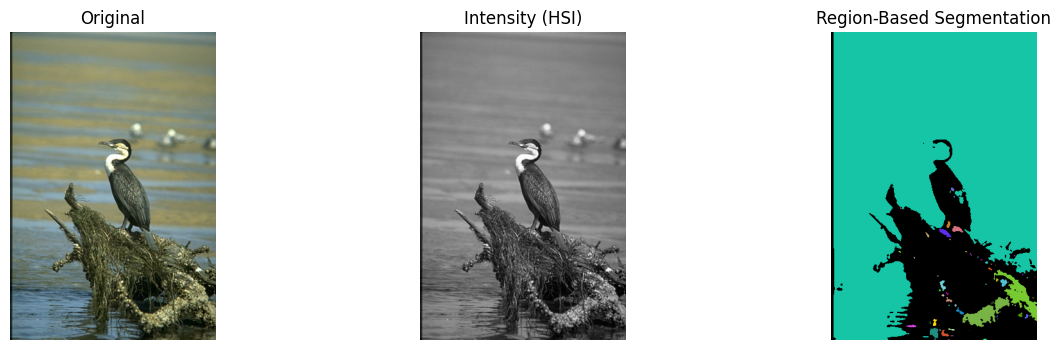

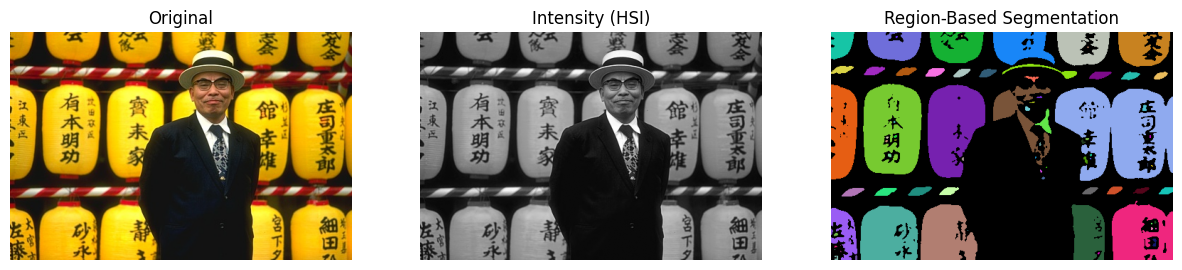

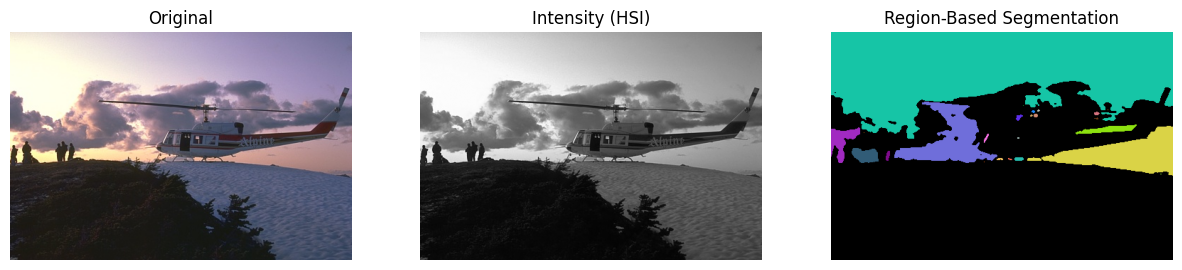

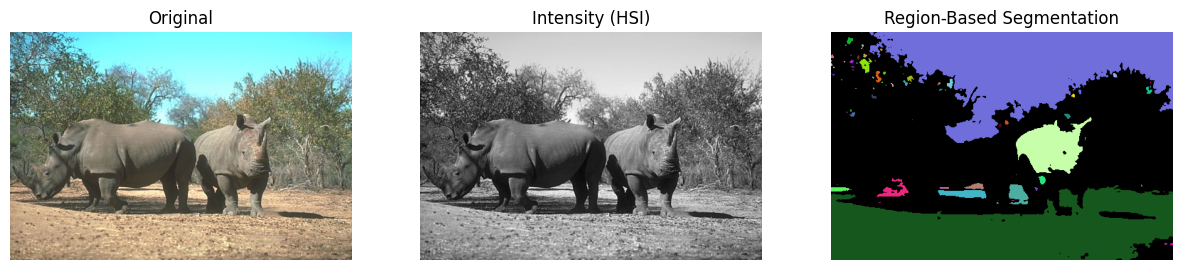

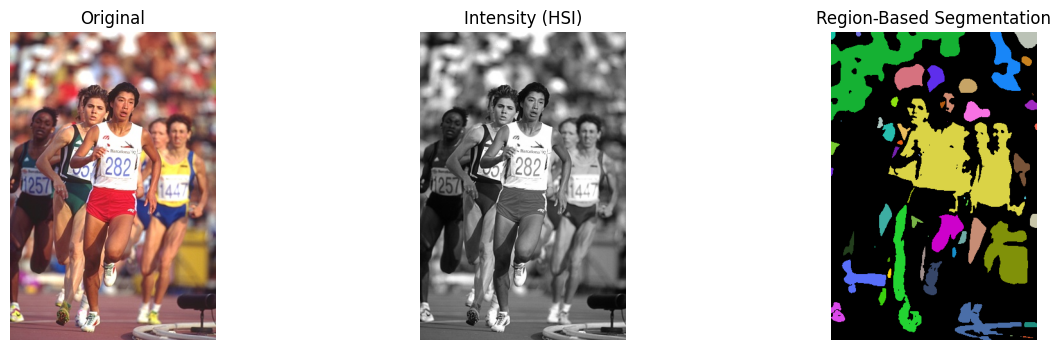

In [ ]:
#8 ana pipeline
image_paths = glob.glob("images/*.jpg")

for path in image_paths:
    img = cv2.imread(path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    H, S, I = rgb_to_hsi(img)
    ms = mean_shift_segmentation(img)

    labels, _ = label_regions_from_meanshift(ms)
    region_vis = visualize_regions(labels)

    plt.figure(figsize=(15,4))

    plt.subplot(1,3,1)
    plt.title("Original")
    plt.imshow(img_rgb)
    plt.axis("off")

    plt.subplot(1,3,2)
    plt.title("Intensity (HSI)")
    plt.imshow(I, cmap="gray")
    plt.axis("off")

    plt.subplot(1,3,3)
    plt.title("Region-Based Segmentation")
    plt.imshow(region_vis)
    plt.axis("off")

    plt.show()


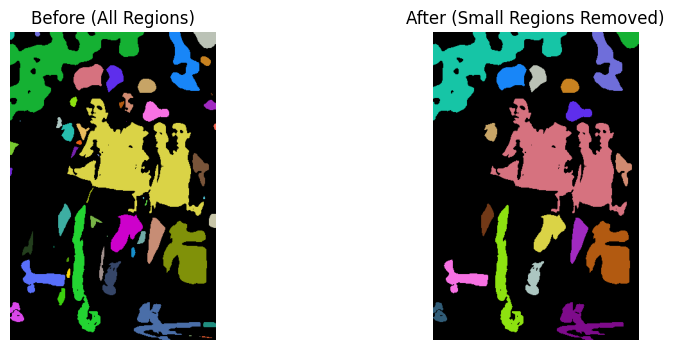

In [ ]:
#İYİLEŞTİRME 1 KARŞILAŞTIRMA (Önce / Sonra)
labels_raw, _ = label_regions_from_meanshift(ms)
labels_clean = remove_small_regions(labels_raw, min_area=400)

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.title("Before (All Regions)")
plt.imshow(visualize_regions(labels_raw))
plt.axis("off")

plt.subplot(1,2,2)
plt.title("After (Small Regions Removed)")
plt.imshow(visualize_regions(labels_clean))
plt.axis("off")

plt.show()


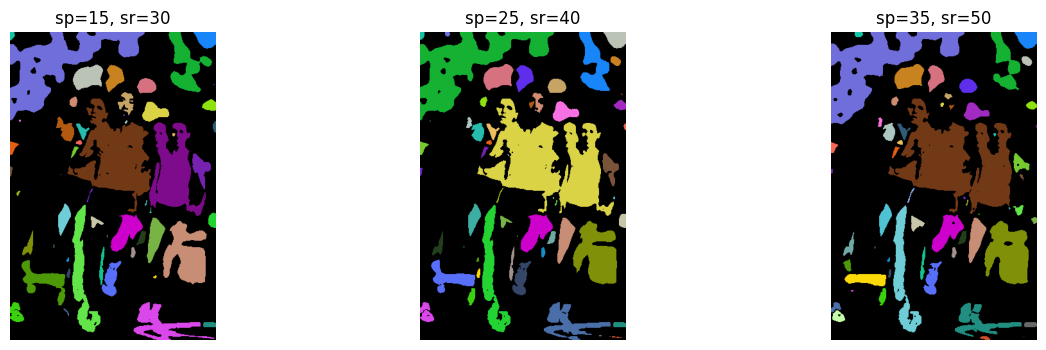

In [ ]:
#İYİLEŞTİRME 2 KARŞILAŞTIRMA (Mean Shift Parametreleri)
params = [(15,30), (25,40), (35,50)]

plt.figure(figsize=(15,4))

for i, (sp, sr) in enumerate(params):
    ms_custom = mean_shift_custom(img, sp, sr)
    labels_custom, _ = label_regions_from_meanshift(ms_custom)
    plt.subplot(1,3,i+1)
    plt.title(f"sp={sp}, sr={sr}")
    plt.imshow(visualize_regions(labels_custom))
    plt.axis("off")

plt.show()


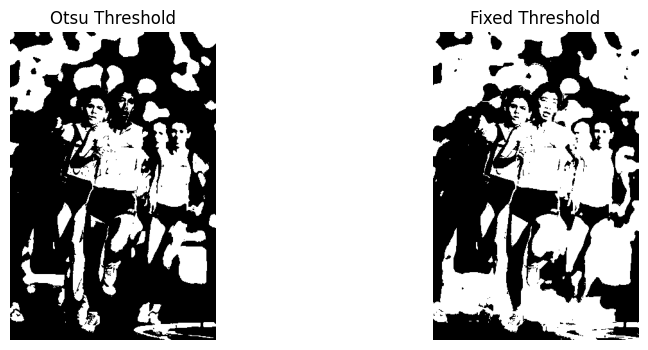

In [ ]:
#İYİLEŞTİRME 3: Threshold Karşılaştırması
gray = cv2.cvtColor(ms, cv2.COLOR_BGR2GRAY)

_, binary_otsu = cv2.threshold(
    gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU
)

_, binary_fixed = cv2.threshold(
    gray, 120, 255, cv2.THRESH_BINARY
)

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.title("Otsu Threshold")
plt.imshow(binary_otsu, cmap="gray")
plt.axis("off")

plt.subplot(1,2,2)
plt.title("Fixed Threshold")
plt.imshow(binary_fixed, cmap="gray")
plt.axis("off")

plt.show()
